In [ ]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import warnings
warnings.filterwarnings(action='ignore')
from catboost import *
import sklearn
import math
from sklearn.preprocessing import LabelEncoder
import math


def log(train,test):
    col_list = train.columns
    for col in col_list :
        if '제곱' in col:
            train[col+'log'] = np.log1p(train[col])
            test[col+'log'] = np.log1p(test[col])
    return train,test

def del_columns(train, test):
    col_list = train.columns
    nan_list = []
    nan_cnt = []
    nan_col = []
    full_list = []
    for col in col_list:
        if train[col].isnull().sum() == 0 :
            full_list.append(col)
            continue
        nan_list.append([col, train[col].isnull().sum()])
        nan_cnt.append(train[col].isnull().sum())
        nan_col.append(col)

    '''모든값이 결측값이면 제거'''
    del_col = []
    for col in nan_list :
        if col[1] == len(train) :
            del_col.append(col[0])
    train = train.drop(columns=del_col)
    test = test.drop(columns=del_col)

    '''값이 1개 존재하면 제거'''
    del_col = []
    col_list = train.describe().columns
    for col in col_list :
        if col == 'Y_Class':
            continue
        if col == 'Y_Quality':
            continue
        if col == 'LINE':
            continue
        if col == 'PRODUCT_CODE':
            continue
        if train[col].nunique()==1 :
            del_col.append(col)
    train = train.drop(columns=del_col)
    test = test.drop(columns=del_col)
    
    return train,test
   
def make_train_test_dataset(train,test):
    train_x = train.drop(columns=['PRODUCT_ID','TIMESTAMP','PRODUCT_CODE','Y_Class','Y_Quality'])
    test_x = test.drop(columns=['PRODUCT_ID','TIMESTAMP','PRODUCT_CODE'])
    train_y = train['Y_Quality']
    train_w = train[['Y_Class']]
    return train_x, test_x, train_y, train_w

def fillna(train,test,value):
    train = train.fillna(value)
    test = test.fillna(value)
    return train,test

def labelencoder(train,test,col_list):
    qual_col = col_list
    for i in qual_col:
        le = LabelEncoder()
        le = le.fit(train[i])
        train[i] = le.transform(train[i])

        for label in np.unique(test[i]): 
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test[i] = le.transform(test[i]) 
    return train,test

def multi_col(train,test) : 
    col_list = train.columns
    for col in col_list :
        if col == 'LINE':
            continue
        train[col+'제곱'] = (train[col]**2)//100
        test[col+'제곱'] = (test[col]**2)//100
    return train,test

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/스마트 공장 제품 품질 상태 분류 AI 온라인 해커톤/train.csv')
test = pd.read_csv('/content/drive/MyDrive/스마트 공장 제품 품질 상태 분류 AI 온라인 해커톤/test.csv')

# y quality scaling
train['Y_Quality'] = train['Y_Quality'].map(lambda x : np.log(x))

train, test = del_columns(train,test)

trainA_31 = train[train['PRODUCT_CODE']=='A_31']
train_T_31 = train[train['PRODUCT_CODE']=='T_31']
train_O_31 = train[train['PRODUCT_CODE']=='O_31']

testA_31 = test[test['PRODUCT_CODE']=='A_31']
test_T_31 = test[test['PRODUCT_CODE']=='T_31']
test_O_31 = test[test['PRODUCT_CODE']=='O_31']

trainA_31, testA_31 = del_columns(trainA_31,testA_31)
train_T_31, test_T_31 = del_columns(train_T_31,test_T_31)
train_O_31, test_O_31 = del_columns(train_O_31,test_O_31)

trainA_31_x,testA_31_x, trainA_31_y, trainA_31_w = make_train_test_dataset(trainA_31,testA_31)
train_T_31_x,test_T_31_x, train_T_31_y, train_T_31_w = make_train_test_dataset(train_T_31,test_T_31)
train_O_31_x,test_O_31_x, train_O_31_y, train_O_31_w = make_train_test_dataset(train_O_31,test_O_31)

trainA_31_x,testA_31_x = labelencoder(trainA_31_x,testA_31_x,['LINE'])
train_T_31_x,test_T_31_x = labelencoder(train_T_31_x,test_T_31_x,['LINE'])
train_O_31_x,test_O_31_x = labelencoder(train_O_31_x,test_O_31_x,['LINE'])

trainA_31_x,testA_31_x = fillna(trainA_31_x,testA_31_x,-1)
train_T_31_x,test_T_31_x = fillna(train_T_31_x,test_T_31_x,-1)
train_O_31_x,test_O_31_x = fillna(train_O_31_x,test_O_31_x,-1)

'''
# 강한 추세성보이는 칼럼 중 일부 제거
drop_a = ['X_1167','X_1168','X_1169','X_1170','X_1171','X_1274','X_1275','X_1276','X_1277','X_1278']
drop_t = ['X_529','X_530','X_531','X_532','X_533','X_600','X_601','X_602','X_603','X_604']

trainA_31_x = trainA_31_x.drop(columns=drop_a)
testA_31_x = testA_31_x.drop(columns=drop_a)
train_T_31_x = train_T_31_x.drop(columns=drop_t)
test_T_31_x = test_T_31_x.drop(columns=drop_t)


trainA_31_x,testA_31_x = multi_col(trainA_31_x,testA_31_x)
train_T_31_x,test_T_31_x = multi_col(train_T_31_x,test_T_31_x)
train_O_31_x,test_O_31_x = multi_col(train_O_31_x,test_O_31_x)

trainA_31_x,testA_31_x = log(trainA_31_x,testA_31_x)
train_T_31_x,test_T_31_x = log(train_T_31_x,test_T_31_x)
train_O_31_x,test_O_31_x = log(train_O_31_x,test_O_31_x)
'''

print(trainA_31_x.shape,testA_31_x.shape,train_T_31_x.shape,test_T_31_x.shape)

(249, 1866) (67, 1866) (343, 550) (239, 550)


In [ ]:
# trainA_31_x[trainA_31_x.std()[trainA_31_x.std() > 1].index] = trainA_31_x[trainA_31_x.std()[trainA_31_x.std() > 1].index].fillna(trainA_31_x[trainA_31_x.std()[trainA_31_x.std() > 1].index].mean())
# testA_31_x[trainA_31_x.std()[trainA_31_x.std() > 1].index] = testA_31_x[trainA_31_x.std()[trainA_31_x.std() > 1].index].fillna(trainA_31_x[trainA_31_x.std()[trainA_31_x.std() > 1].index].mean())
# train_T_31_x[train_T_31_x.std()[train_T_31_x.std() > 1].index] = train_T_31_x[train_T_31_x.std()[train_T_31_x.std() > 1].index].fillna(train_T_31_x[train_T_31_x.std()[train_T_31_x.std() > 1].index].mean())
# test_T_31_x[train_T_31_x.std()[train_T_31_x.std() > 1].index] = test_T_31_x[train_T_31_x.std()[train_T_31_x.std() > 1].index].fillna(train_T_31_x[train_T_31_x.std()[train_T_31_x.std() > 1].index].mean())
# train_O_31_x[train_O_31_x.std()[train_O_31_x.std() > 1].index] = train_O_31_x[train_O_31_x.std()[train_O_31_x.std() > 1].index].fillna(train_O_31_x[train_O_31_x.std()[train_O_31_x.std() > 1].index].mean())
# test_O_31_x[train_O_31_x.std()[train_O_31_x.std() > 1].index] = test_O_31_x[train_O_31_x.std()[train_O_31_x.std() > 1].index].fillna(train_O_31_x[train_O_31_x.std()[train_O_31_x.std() > 1].index].mean())

# trainA_31_x=trainA_31_x.fillna(trainA_31_x.min())
# testA_31_x=testA_31_x.fillna(trainA_31_x.min())
# train_T_31_x=train_T_31_x.fillna(train_T_31_x.min())
# test_T_31_x=test_T_31_x.fillna(train_T_31_x.min())
# train_O_31_x=train_O_31_x.fillna(train_O_31_x.min())
# test_O_31_x=test_O_31_x.fillna(train_O_31_x.min())

In [ ]:
# trainA_31_x[trainA_31_x.std()[trainA_31_x.std() < 1].index] = trainA_31_x[trainA_31_x.std()[trainA_31_x.std() < 1].index].fillna(trainA_31_x[trainA_31_x.std()[trainA_31_x.std() < 1].index].min())
# testA_31_x[trainA_31_x.std()[trainA_31_x.std() < 1].index] = testA_31_x[trainA_31_x.std()[trainA_31_x.std() < 1].index].fillna(trainA_31_x[trainA_31_x.std()[trainA_31_x.std() < 1].index].min())
# train_T_31_x[train_T_31_x.std()[train_T_31_x.std() < 1].index] = train_T_31_x[train_T_31_x.std()[train_T_31_x.std() < 1].index].fillna(train_T_31_x[train_T_31_x.std()[train_T_31_x.std() < 1].index].min())
# test_T_31_x[train_T_31_x.std()[train_T_31_x.std() < 1].index] = test_T_31_x[train_T_31_x.std()[train_T_31_x.std() < 1].index].fillna(train_T_31_x[train_T_31_x.std()[train_T_31_x.std() < 1].index].min())
# train_O_31_x[train_O_31_x.std()[train_O_31_x.std() < 1].index] = train_O_31_x[train_O_31_x.std()[train_O_31_x.std() < 1].index].fillna(train_O_31_x[train_O_31_x.std()[train_O_31_x.std() < 1].index].min())
# test_O_31_x[train_O_31_x.std()[train_O_31_x.std() < 1].index] = test_O_31_x[train_O_31_x.std()[train_O_31_x.std() < 1].index].fillna(train_O_31_x[train_O_31_x.std()[train_O_31_x.std() < 1].index].min())


# # knnimputer 사용
# from sklearn.impute import KNNImputer

# imputer=KNNImputer(n_neighbors=5)

# trainA_31_x[trainA_31_x.filter(regex='X').columns] = imputer.fit_transform(trainA_31_x.filter(regex='X'))
# testA_31_x[testA_31_x.filter(regex='X').columns] = imputer.transform(testA_31_x.filter(regex='X'))

# imputer=KNNImputer(n_neighbors=5)

# train_T_31_x[train_T_31_x.filter(regex='X').columns] = imputer.fit_transform(train_T_31_x.filter(regex='X'))
# test_T_31_x[test_T_31_x.filter(regex='X').columns] = imputer.transform(test_T_31_x.filter(regex='X'))

# imputer=KNNImputer(n_neighbors=5)

# train_O_31_x[train_O_31_x.filter(regex='X').columns] = imputer.fit_transform(train_O_31_x.filter(regex='X'))
# test_O_31_x[test_O_31_x.filter(regex='X').columns] = imputer.transform(test_O_31_x.filter(regex='X'))

In [ ]:
# drop_cols = trainA_31_x.T[trainA_31_x.T.duplicated()].index

# trainA_31_x = trainA_31_x.drop(columns=drop_cols)
# testA_31_x = testA_31_x.drop(columns=drop_cols)

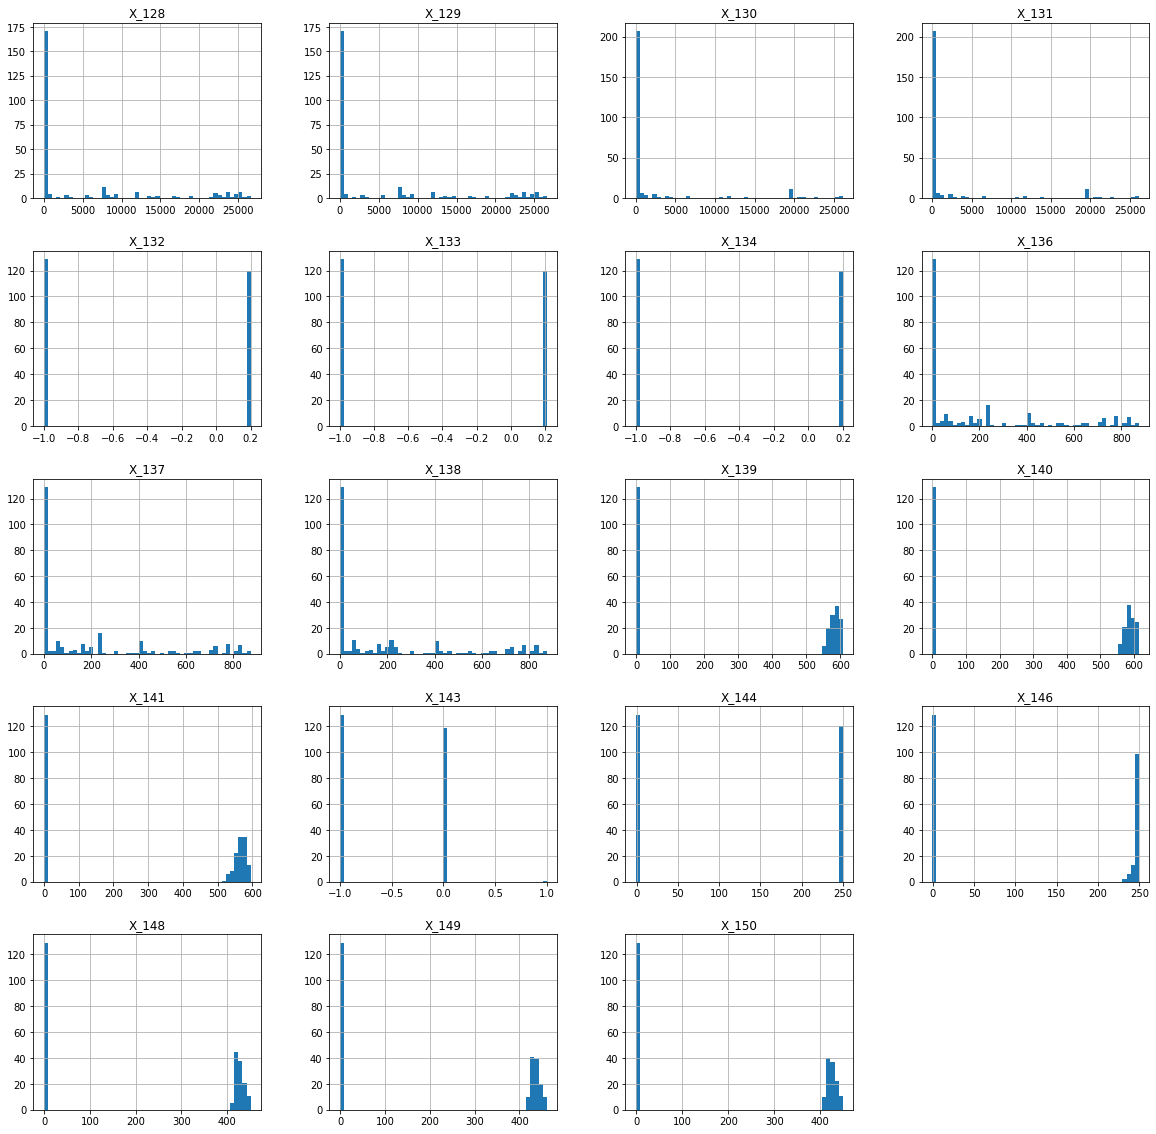

In [ ]:
trainA_31_x.iloc[:, 1:20].hist(bins = 50, figsize = (20,20))
plt.show()

In [ ]:
import collections
from sklearn.decomposition import PCA

drops = []
cols = collections.defaultdict(list)

corr = trainA_31_x.corr()

for i in range(len(trainA_31_x.columns[1:])):
    col = trainA_31_x.columns[1:][i]
    if col in drops:
        continue
    for j in range(i+1, len(trainA_31_x.columns[1:])):
        col2 = trainA_31_x.columns[1:][j]
        if corr[col][col2] < 0.99:
            break
        cols[col].append(col2)
        drops.append(col2)

a_cols = []

for i in cols:
    cols[i].append(i)
    a_cols.append(cols[i])

for cols in a_cols:
    pca = PCA(n_components=len(cols)//2)
    trainA_31_x[cols[:len(cols)//2]] = pca.fit_transform(trainA_31_x[cols])
    trainA_31_x = trainA_31_x.drop(columns=cols[len(cols)//2:])
    
    testA_31_x[cols[:len(cols)//2]] = pca.transform(testA_31_x[cols])
    testA_31_x = testA_31_x.drop(columns=cols[len(cols)//2:])

drops = []
cols = collections.defaultdict(list)

corr = train_T_31_x.corr()

for i in range(len(train_T_31_x.columns[1:])):
    col = train_T_31_x.columns[1:][i]
    if col in drops:
        continue
    for j in range(i+1, len(train_T_31_x.columns[1:])):
        col2 = train_T_31_x.columns[1:][j]
        if corr[col][col2] < 0.99:
            break
        cols[col].append(col2)
        drops.append(col2)

a_cols = []

for i in cols:
    cols[i].append(i)
    a_cols.append(cols[i])

for cols in a_cols:
    pca = PCA(n_components=len(cols)//2)
    train_T_31_x[cols[:len(cols)//2]] = pca.fit_transform(train_T_31_x[cols])
    train_T_31_x = train_T_31_x.drop(columns=cols[len(cols)//2:])
    
    test_T_31_x[cols[:len(cols)//2]] = pca.transform(test_T_31_x[cols])
    test_T_31_x = test_T_31_x.drop(columns=cols[len(cols)//2:])


drops = []
cols = collections.defaultdict(list)

corr = train_O_31_x.corr()

for i in range(len(train_O_31_x.columns[1:])):
    col = train_O_31_x.columns[1:][i]
    if col in drops:
        continue
    for j in range(i+1, len(train_O_31_x.columns[1:])):
        col2 = train_O_31_x.columns[1:][j]
        if corr[col][col2] < 0.99:
            break
        cols[col].append(col2)
        drops.append(col2)

a_cols = []

for i in cols:
    cols[i].append(i)
    a_cols.append(cols[i])

for cols in a_cols:
    pca = PCA(n_components=len(cols)//2)
    train_O_31_x[cols[:len(cols)//2]] = pca.fit_transform(train_O_31_x[cols])
    train_O_31_x = train_O_31_x.drop(columns=cols[len(cols)//2:])
    
    test_O_31_x[cols[:len(cols)//2]] = pca.transform(test_O_31_x[cols])
    test_O_31_x = test_O_31_x.drop(columns=cols[len(cols)//2:])

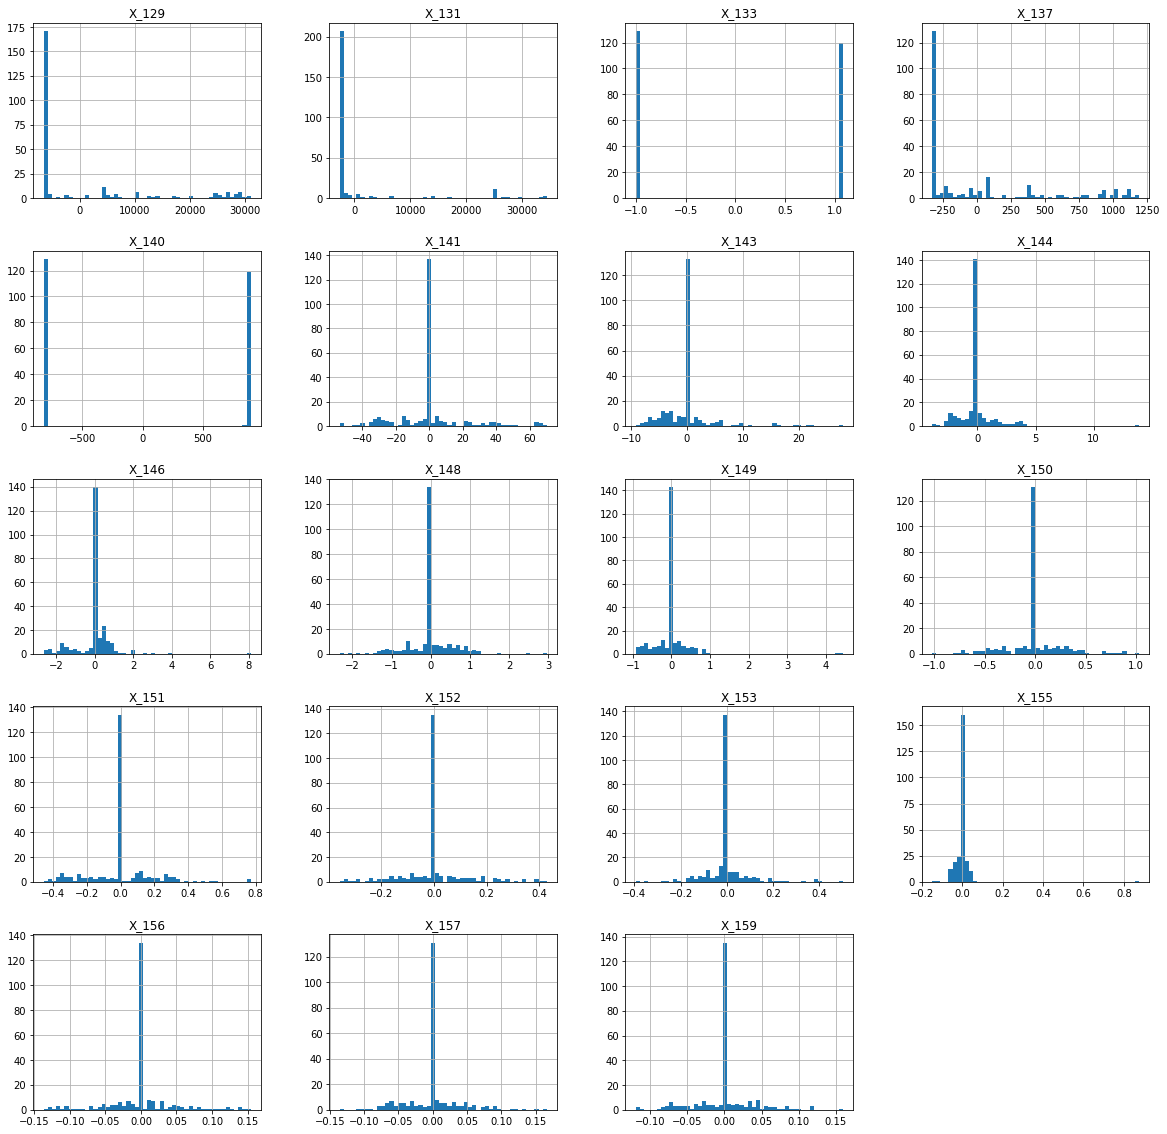

In [ ]:
trainA_31_x.iloc[:, 1:20].hist(bins = 50, figsize = (20,20))
plt.show()

In [ ]:
print(train[train['Y_Class']==0]['Y_Quality'].max(),'\n',
      train[train['Y_Class']==1]['Y_Quality'].min(),'\n',
      train[train['Y_Class']==1]['Y_Quality'].max(),'\n',
      train[train['Y_Class']==2]['Y_Quality'].min(),'\n')

-0.6442300396904909 
 -0.6441937649548493 
 -0.6257823004654807 
 -0.6255805101477584 



In [ ]:
model = CatBoostRegressor(random_state=1234,verbose=500,iterations=1500,learning_rate=0.033)

In [ ]:
model.fit(trainA_31_x, trainA_31_y)
pred_a = model.predict(testA_31_x)

0:	learn: 0.0183635	total: 328ms	remaining: 8m 12s
500:	learn: 0.0008846	total: 2m 19s	remaining: 4m 38s
1000:	learn: 0.0000703	total: 4m 20s	remaining: 2m 9s
1499:	learn: 0.0000066	total: 6m 14s	remaining: 0us


In [ ]:
model.fit(train_T_31_x, train_T_31_y)
pred_t = model.predict(test_T_31_x)

0:	learn: 0.0089082	total: 97.5ms	remaining: 2m 26s
500:	learn: 0.0008882	total: 39.6s	remaining: 1m 18s
1000:	learn: 0.0000963	total: 1m 19s	remaining: 39.8s
1499:	learn: 0.0000103	total: 1m 58s	remaining: 0us


In [ ]:
model.fit(train_O_31_x, train_O_31_y)
pred_o = model.predict(test_O_31_x)

0:	learn: 0.0059792	total: 18.5ms	remaining: 27.7s
500:	learn: 0.0000912	total: 4.13s	remaining: 8.24s
1000:	learn: 0.0000014	total: 9.07s	remaining: 4.52s
1499:	learn: 0.0000000	total: 12.5s	remaining: 0us


In [ ]:
testA_31['Y_quanlity'] = pred_a
test_T_31['Y_quanlity'] = pred_t
test_O_31['Y_quanlity'] = pred_o

testA_31['Y_Class'] = 1
test_T_31['Y_Class'] = 1
test_O_31['Y_Class'] = 1

testA_31.loc[(testA_31['Y_quanlity']<-0.64421190232267), 'Y_Class'] = 0
testA_31.loc[(testA_31['Y_quanlity']>-0.6256814053066195), 'Y_Class'] = 2
test_T_31.loc[(test_T_31['Y_quanlity']<-0.64421190232267), 'Y_Class'] = 0
test_T_31.loc[(test_T_31['Y_quanlity']>-0.6256814053066195), 'Y_Class'] = 2
test_O_31.loc[(test_O_31['Y_quanlity']<-0.64421190232267), 'Y_Class'] = 0
test_O_31.loc[(test_O_31['Y_quanlity']>-0.6256814053066195), 'Y_Class'] = 2

submita = pd.read_csv('/content/drive/MyDrive/스마트 공장 제품 품질 상태 분류 AI 온라인 해커톤/sample_submission.csv')
submitt = pd.read_csv('/content/drive/MyDrive/스마트 공장 제품 품질 상태 분류 AI 온라인 해커톤/sample_submission.csv')
submito = pd.read_csv('/content/drive/MyDrive/스마트 공장 제품 품질 상태 분류 AI 온라인 해커톤/sample_submission.csv')

submita = pd.merge(submita[['PRODUCT_ID']],testA_31[['PRODUCT_ID','Y_Class']],on='PRODUCT_ID')
submitt = pd.merge(submitt[['PRODUCT_ID']],test_T_31[['PRODUCT_ID','Y_Class']],on='PRODUCT_ID')
submito = pd.merge(submito[['PRODUCT_ID']],test_O_31[['PRODUCT_ID','Y_Class']],on='PRODUCT_ID')

submit = pd.concat([submita,submitt,submito]).sort_values(by='PRODUCT_ID')
submit.to_csv('scale1.csv',index=False)

In [ ]:
submita['Y_Class'].value_counts()

1    47
2    13
0     7
Name: Y_Class, dtype: int64

In [ ]:
submitt['Y_Class'].value_counts()

1    229
2      6
0      4
Name: Y_Class, dtype: int64

In [ ]:
submito['Y_Class'].value_counts()

1    4
Name: Y_Class, dtype: int64

In [ ]:
submit['Y_Class'].value_counts()

1    280
2     19
0     11
Name: Y_Class, dtype: int64